In [1]:
# Intro
# Data Set: FD003
# Train trjectories: 100
# Test trajectories: 100
# Operating conditions: ONE
# Fault Modes: TWO (HPC Degradation, Fan Degradation)

In [2]:
#<disclaimer: I aim to showcase the effect of different methods and choices made during model development. These effects are often shown using the test set, something which is considered (very) bad practice but helps for educational purposes.>

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# from sklearn.tree import export_graphviz
# import graphviz

ModuleNotFoundError: No module named 'graphviz'

In [6]:
pwd()

'/Users/Shikhar/Desktop/Downloads/CMaps'

In [7]:
# define filepath and files to read data
dir_path = '/Users/Shikhar/Desktop/Downloads/CMaps/'
train_file = 'train_FD003.txt'
test_file = 'test_FD003.txt'

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+train_file), sep='\s+', header=None, 
                 names=col_names)
test = pd.read_csv((dir_path+test_file), sep='\s+', header=None, 
                 names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD003.txt'), sep='\s+', header=None, 
                 names=['RemainingUsefulLife'])

In [8]:
print(train.shape)
train.head()

(24720, 26)


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


In [9]:
#EDA
# inspect unit_nr
train[index_names].describe()

,unit_nr,time_cycles
count,24720.000000,24720.000000
mean,48.631877,139.077063
std,29.348985,98.846675
min,1.000000,1.000000
25%,23.000000,62.000000
50%,47.000000,124.000000
75%,74.000000,191.000000
max,100.000000,525.000000


In [10]:
# inspect time cycles
train[index_names].groupby('unit_nr').max().describe()

,time_cycles
count,100.00000
mean,247.20000
std,86.48384
min,145.00000
25%,189.75000
50%,220.50000
75%,279.75000
max,525.00000


In [11]:
# inspect sensor values, specifically if there are any with near 0 standard deviation 
# (sensors readings which do not change over time hold no information)
train[sensor_names].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s_1,24720.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,24720.0,642.457858,5.230311e-01,640.8400,642.0800,642.4000,642.7900,645.1100
s_3,24720.0,1588.079175,6.810418e+00,1564.3000,1583.2800,1587.5200,1592.4125,1615.3900
s_4,24720.0,1404.471212,9.773178e+00,1377.0600,1397.1875,1402.9100,1410.6000,1441.1600
s_5,24720.0,14.620000,3.552786e-15,14.6200,14.6200,14.6200,14.6200,14.6200
s_6,24720.0,21.595841,1.811600e-02,21.4500,21.5800,21.6000,21.6100,21.6100
s_7,24720.0,555.143808,3.437343e+00,549.6100,553.1100,554.0500,556.0400,570.4900
s_8,24720.0,2388.071555,1.582849e-01,2386.9000,2388.0000,2388.0700,2388.1400,2388.6000
s_9,24720.0,9064.110809,1.998029e+01,9017.9800,9051.9200,9060.0100,9070.0925,9234.3500
s_10,24720.0,1.301232,3.484849e-03,1.2900,1.3000,1.3000,1.3000,1.3200


In [12]:
#Sensors 1, 5, 16, 18 and 19 can be excluded based on their standard deviation

In [13]:
#Plotting

In [14]:
# before we start plotting, let's add RUL
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,258
1,1,2,257
2,1,3,256
3,1,4,255
4,1,5,254


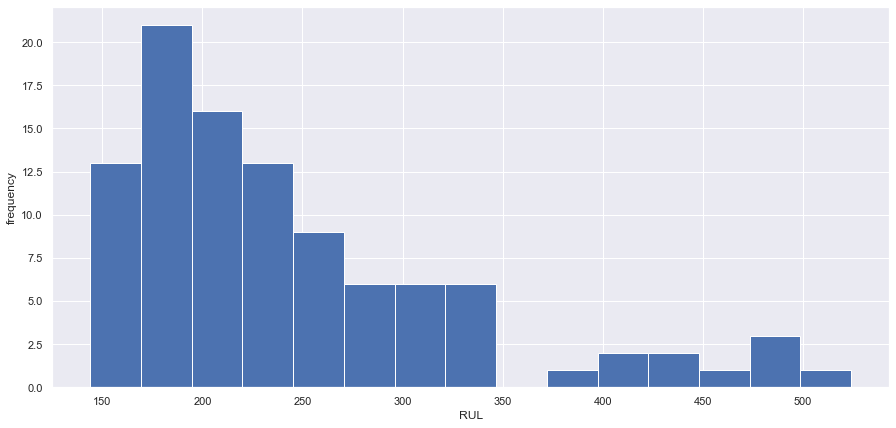

In [15]:
# distribution of RUL, similar to the 'describe function' of time_cycles above, but visual
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').first().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel("RUL")
plt.ylabel("frequency")
plt.show()

#### We'll clip the RUL further down below, this plot just goes to show the distribution of linearly decreasing RUL and how skewed that distribution is.

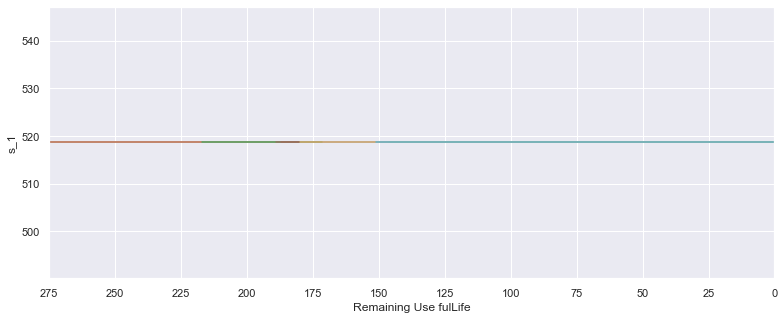

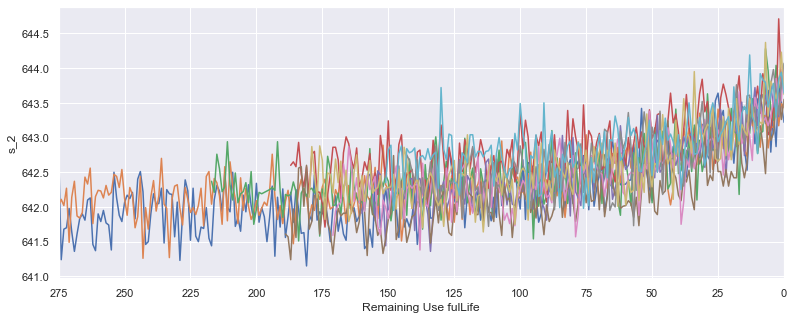

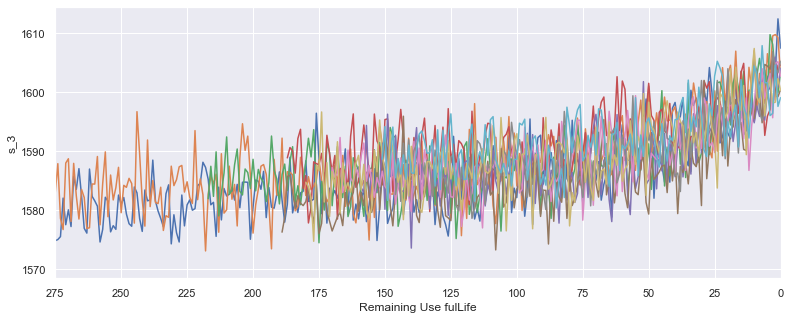

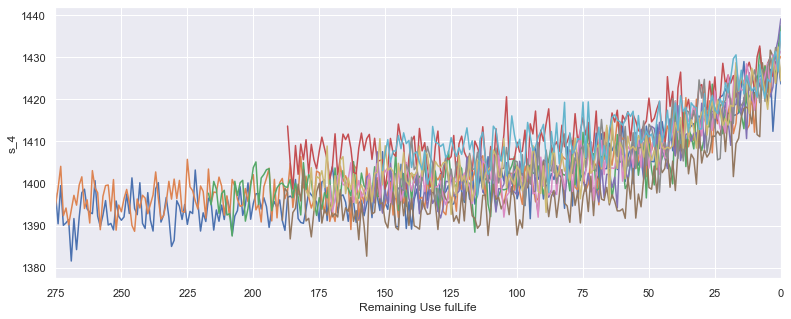

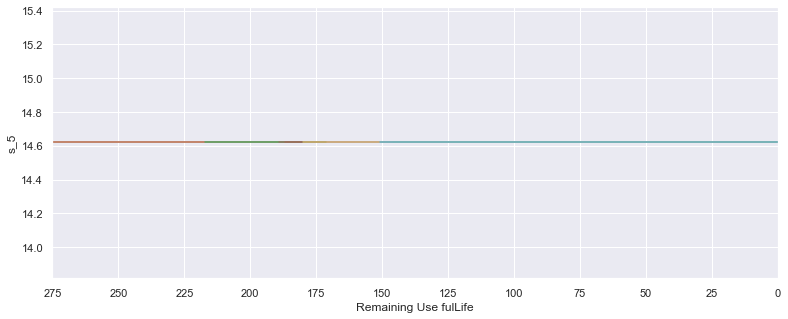

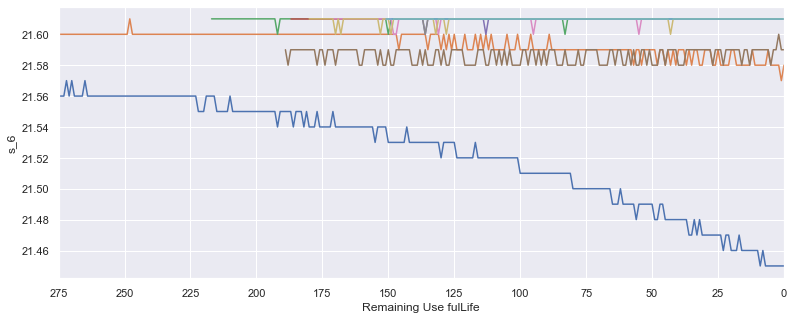

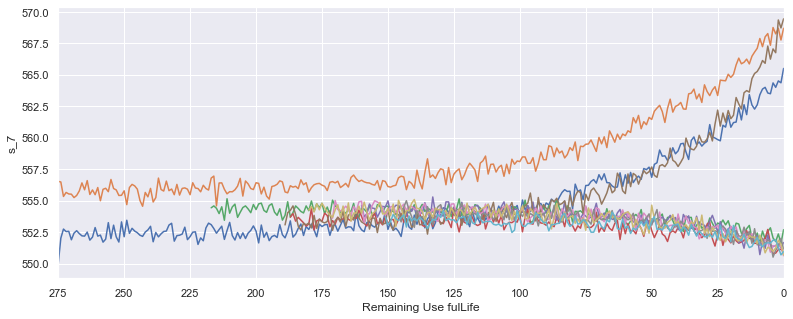

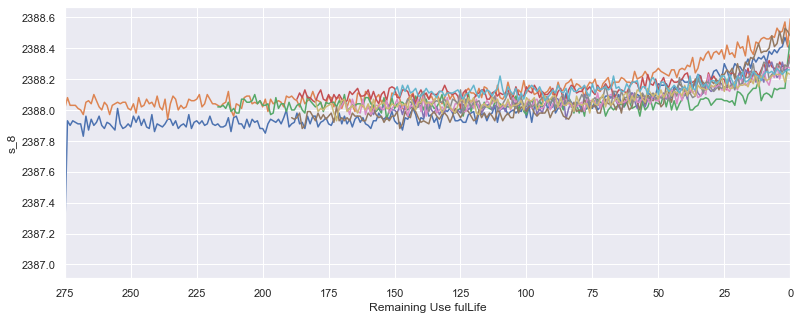

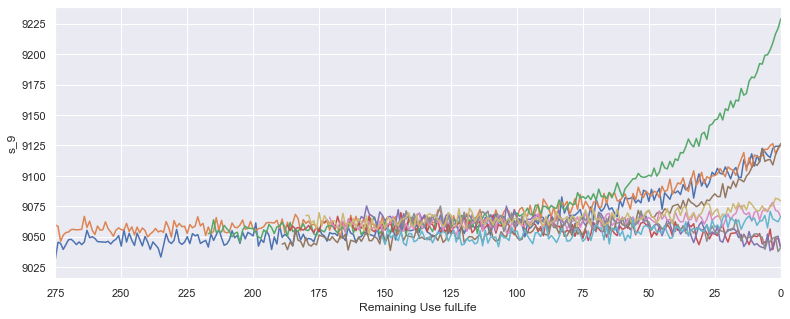

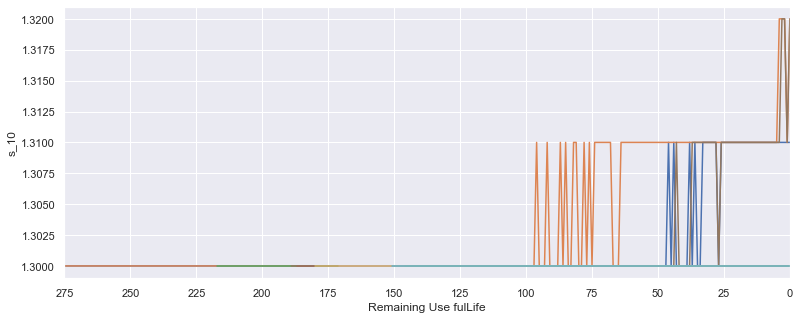

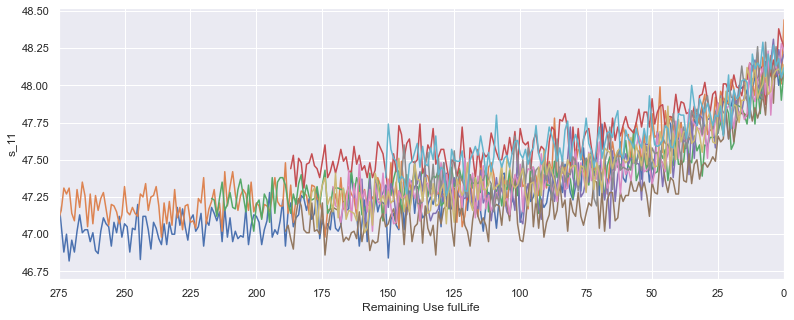

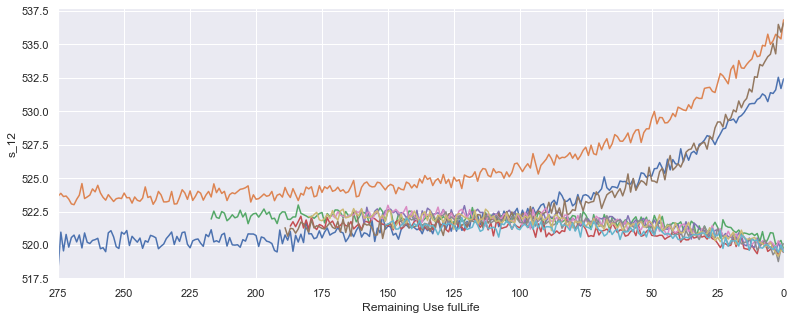

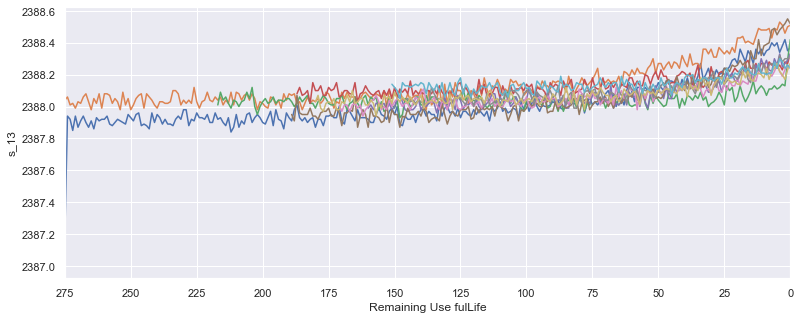

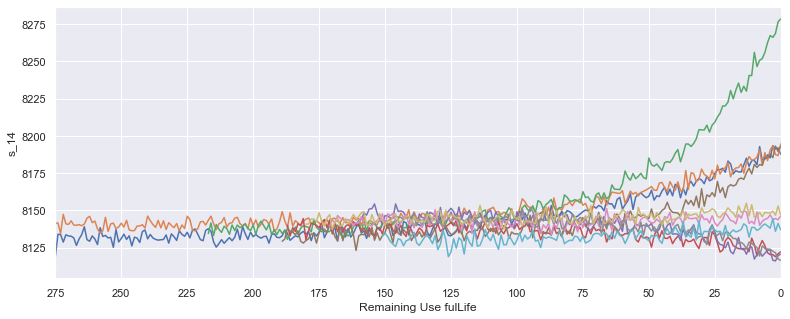

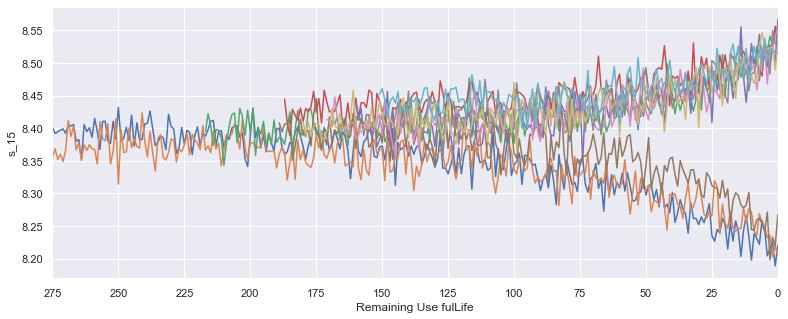

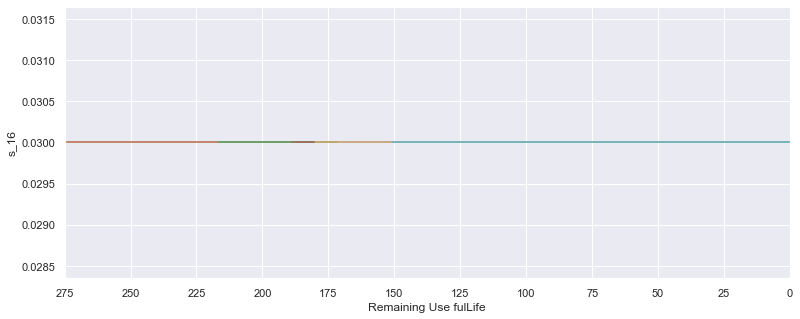

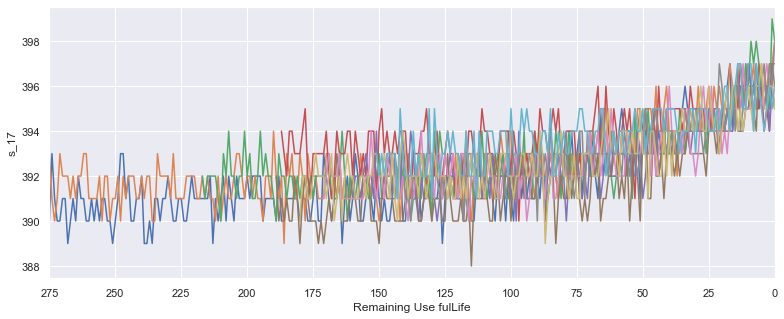

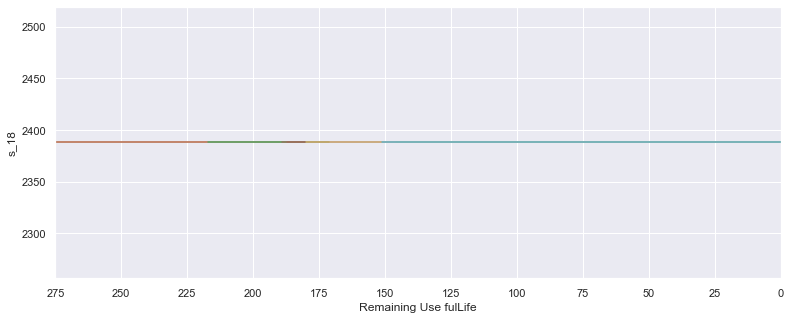

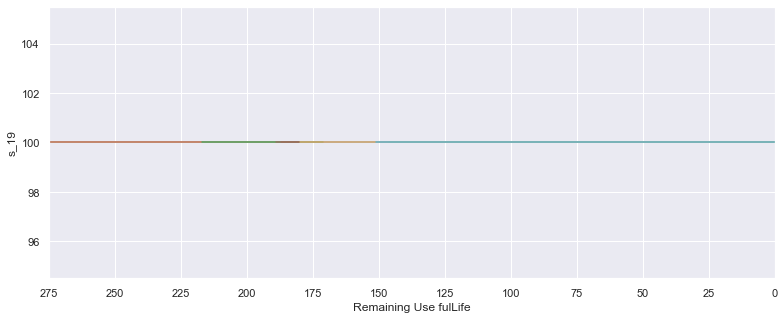

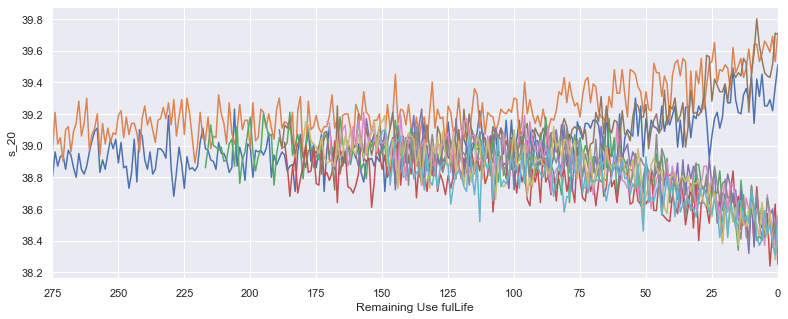

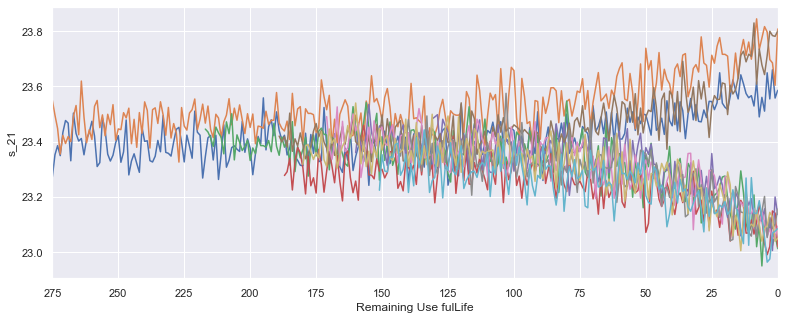

In [16]:
def plot_signal(df, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_nr'].unique():
        if (i % 10 == 0):  
            plt.plot('RUL', signal_name, 
                     data=df[df['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

for sensor in sensor_names:
    plot_signal(train, sensor)

## Baseline model and initial RF

In [17]:
# prep data
# drop unwanted columns and split target variable from training set
drop_sensors = ['s_1','s_5','s_16','s_18','s_19']  # s_6 and s_10 get the benefit of the doubt
drop_labels = index_names+setting_names+drop_sensors
remaining_sensors = ['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_10',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']


X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')
y_train_clipped = y_train.clip(upper=125)  # apply RUL clipping from earlier

# Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
X_test = test.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)

In [18]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [19]:
lm = LinearRegression()
lm.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:19.33013490506066, R2:0.7736110804777456
test set RMSE:22.319344484399124, R2:0.7092939799791518


In [20]:
# bare random forest regressor
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42)
rf.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:5.9199939580022525, R2:0.9787661901585051
test set RMSE:21.05308450085165, R2:0.7413439613827657


#### The Random Forest outperformes the linear regression right off the bat. However, judging by the difference in train and test RMSE it is quite overfit

In [22]:
# perform some checks on tree layout
print(rf.estimators_[5].tree_.max_depth)  # check how many nodes in the longest path
rf.estimators_[5].tree_.n_node_samples    # check how many samples in the last nodes

33


array([15616, 11694,  7793, ...,     1,     1,     4], dtype=int64)

In [23]:
# crudely tweaked random forest
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42, 
                           max_depth=8, min_samples_leaf=50)
rf.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:15.706704198492831, R2:0.8505294865338602
test set RMSE:20.994958823842456, R2:0.7427702419664686


#### By crudely tweaking the Random Forest we can reduce overfitting while gaining a slight performance increase.

## Hyperparameters

In [24]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 8,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 50,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

#### CCP Alpha

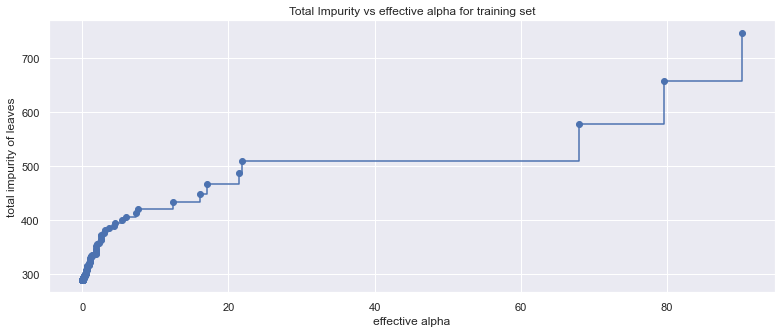

In [25]:
# get ccp_alphas
path = rf.estimators_[5].cost_complexity_pruning_path(X_train, y_train_clipped)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots(figsize=(13,5))
# the root node of the tree (indexed with [:-1]) is left out of the analysis, as without it there wouldn't be a tree
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")  
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

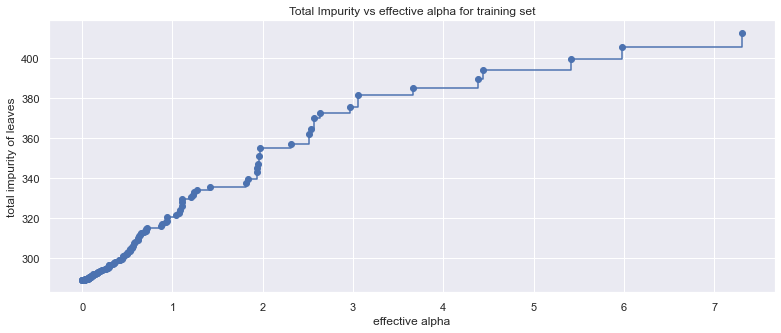

In [26]:
# zoom in
fig, ax = plt.subplots(figsize=(13,5))
ax.plot(ccp_alphas[:-10], impurities[:-10], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

##### Effective alpha's below 2 have the highest cost complexity, but leaf impurity is also lowered by an additional 50 points (~7 train RMSE). This seems like a suitable range to use for hyperparameter tuning.

#### min impurity decrease

In [27]:
rf_dict = {
    'id_node': list(range(rf.estimators_[5].tree_.node_count)),
    'impurity': rf.estimators_[5].tree_.impurity,
    'samples': rf.estimators_[5].tree_.n_node_samples,
    'id_left_child': rf.estimators_[5].tree_.children_left,
    'id_right_child': rf.estimators_[5].tree_.children_right
}

impurity_df = pd.DataFrame(rf_dict)
print(impurity_df.shape)
impurity_df.head(10)

(227, 5)


,id_node,impurity,samples,id_left_child,id_right_child
0,0,1644.689840,15616,1,128
1,1,609.414829,11694,2,71
2,2,247.609863,7793,3,52
3,3,156.037153,6372,4,29
4,4,97.827624,4473,5,20
5,5,19.630575,1627,6,13
6,6,3.844416,765,7,10
7,7,10.192376,257,8,9
8,8,1.085113,143,-1,-1
9,9,21.980353,114,-1,-1


In [28]:
# check if all leaf nodes have value -1 for left and right child nodes
impurity_df.loc[impurity_df['id_left_child'] == -1, 'id_right_child'].unique()
impurity_df.loc[impurity_df['id_right_child'] == -1, 'id_left_child'].unique()  # yes they do

array([-1])

In [29]:
impurity_df['impurity_decrease'] = np.nan
samples_total = rf.estimators_[5].tree_.node_count

for idx in impurity_df.index[1:]:  # skip the first node, there aren't any splits prior to it
    if impurity_df.iloc[idx]['id_left_child'] == -1:
        continue  # we can't calculeate impurity decrease for leave nodes, as they no longer split
    else:
        impurity_P, samples_P = impurity_df.iloc[idx][['impurity', 'samples']]
        id_L, id_R = impurity_df.iloc[idx][['id_left_child', 'id_right_child']].astype(int)
        impurity_L, samples_L = impurity_df.iloc[id_L][['impurity', 'samples']]
        impurity_R, samples_R = impurity_df.iloc[id_R][['impurity', 'samples']]
        
        impurity_decrease = samples_P / samples_total * (
            impurity_P - samples_R / samples_P * impurity_R - 
            samples_L / samples_P * impurity_L
            )
        impurity_df.at[idx, 'impurity_decrease'] = impurity_decrease

<AxesSubplot:ylabel='Frequency'>

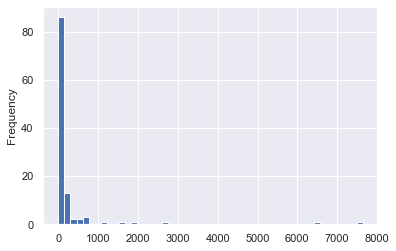

In [30]:
impurity_df['impurity_decrease'].plot(kind='hist', bins=50)


In [32]:
impurity_df['impurity_decrease'].describe()


count     112.000000
mean      282.515265
std       994.407842
min        -0.506232
25%        14.589094
50%        47.024819
75%       129.095879
max      7639.300570
Name: impurity_decrease, dtype: float64

<AxesSubplot:ylabel='Frequency'>

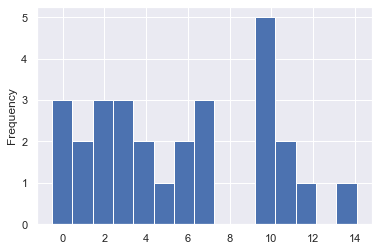

In [34]:
impurity_df.loc[impurity_df['impurity_decrease'] < 14.59, 'impurity_decrease'].plot(kind='hist', bins=15)


In [31]:
# The impurity decrease is very right skewed, this can be explained by the first few nodes of the tree contributing a lot to decreasing error. Checking the descriptives shows 25% of the values for impurity decrease lie below 14.59, which seems a suitable upper-bound for the min_impurity_decrease paramete

#### The 25th percentile seems like a nice upper-bound for the min_impurity_decrease parameter

## Gridsearch


In [35]:
from sklearn.model_selection import RandomizedSearchCV, GroupKFold


In [36]:
max_depth = [None] + list(range(3, 34, 3))  # max depth of the first RF was 33, I don't expect we need bigger depth
min_samples_leaf = list(range(1, 102, 10))  # with crude tweaking we set this to 50, for grid search I'll allow double
min_impurity_decrease = list(np.arange(0,147)/10)  
ccp_alpha = list(np.round(np.linspace(0, 2, 81), decimals=3))  

parameters = {
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_impurity_decrease': min_impurity_decrease,
    'ccp_alpha': ccp_alpha
}


In [37]:
tuning_options = len(max_depth) * len(min_samples_leaf) * len(min_impurity_decrease) * len(ccp_alpha)
print(tuning_options)

1571724


In [38]:
ITERATIONS = 300

rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42)
gkf = GroupKFold(n_splits=3)


regressor = RandomizedSearchCV(rf, 
                               parameters, 
                               cv = gkf.split(train, groups=train['unit_nr']),
                               verbose=2, 
                               error_score='raise',
                               n_iter=ITERATIONS, 
                               n_jobs=-2,
                               # scoring https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                               scoring= 'neg_root_mean_squared_error')  
regressor.fit(X_train, y_train_clipped)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f87109dedd0>,
                   error_score='raise',
                   estimator=RandomForestRegressor(max_features='sqrt',
                                                   random_state=42),
                   n_iter=300, n_jobs=-2,
                   param_distributions={'ccp_alpha': [0.0, 0.025, 0.05, 0.075,
                                                      0.1, 0.125, 0.15, 0.175,
                                                      0.2, 0.225, 0.25, 0.275,
                                                      0.3, 0.325, 0.35, 0.375,
                                                      0.4, 0.425, 0.45, 0.475,
                                                      0.5, 0.525, 0.55, 0.575,
                                                      0.6, 0.625, 0.65, 0.675,
                                                      0.7, 0.725, ...],
                                        'max_depth': [None, 3, 6, 9, 12, 15

In [39]:
results = pd.DataFrame(regressor.cv_results_)
columns = ['param_min_samples_leaf', 'param_min_impurity_decrease', 'param_max_depth', 'param_ccp_alpha', 
           'mean_test_score', 'std_test_score', 'rank_test_score']
results[columns].sort_values('mean_test_score', ascending=False)

,param_min_samples_leaf,param_min_impurity_decrease,param_max_depth,param_ccp_alpha,mean_test_score,std_test_score,rank_test_score
225,11,0.3,33,0.5,-16.660901,0.306160,1
111,31,0.5,12,0.25,-16.822647,0.326526,2
190,11,1.0,21,0.725,-16.921840,0.280323,3
21,41,0.2,33,0.85,-16.950894,0.374097,4
236,1,1.1,15,0.225,-16.966544,0.289403,5
...,...,...,...,...,...,...,...
169,21,12.9,3,0.35,-19.115780,0.512498,296
113,21,13.2,3,1.5,-19.118310,0.513458,297
268,51,12.3,3,0.7,-19.119208,0.520522,298
11,71,13.5,3,0.875,-19.121937,0.512523,299


In [40]:
## Final model

print(regressor.best_params_)
print(regressor.best_score_)

# best try
# {'min_samples_leaf': 11, 'min_impurity_decrease': 0.3, 'max_depth': 33, 'ccp_alpha': 0.5}
# -16.660901200729306

{'min_samples_leaf': 11, 'min_impurity_decrease': 0.3, 'max_depth': 33, 'ccp_alpha': 0.5}
-16.660901200729306


In [41]:
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42,
                           min_samples_leaf=11, min_impurity_decrease=0.3, 
                           max_depth=33, ccp_alpha=0.5)
rf.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:15.271424070370747, R2:0.8586992486516456
test set RMSE:20.968346688882196, R2:0.7434219312251856


## The test RMSE of 20.968 is a a (22.319 - 20.968) / 22.319 * 100 = 6.05% improvement over our baseline model.